## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==2.0.0

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.utils.data 
import pandas as pd
#import helper
from collections import OrderedDict
from PIL import Image
import seaborn as sns

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets

# Define transformations for the training data:
# Random rotations, resizing and cropping, and flips augment the dataset
# Finally, the images are converted to tensors and normalized to match the model expectations
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Define transformations for the validation and test data:
# Images are resized and center-cropped to the same size as training images,
# then converted to tensors and normalized similarly to the training images
valid_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

data_transforms = {
    "train": train_transforms,
    "valid": valid_transforms,
    "test": test_transforms,
}

# TODO: Load the datasets with ImageFolder

# Load the datasets using the ImageFolder utility class,
# which assumes that images are organized in a directory per class
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

image_datasets = {
    "train": train_data,
    "valid": valid_data,
    "test": test_data,
}

# TODO: Using the image datasets and the trainforms, define the dataloaders

# Define the dataloaders that will handle batching for our datasets
# Training dataloader will shuffle images to ensure randomization
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)


dataloaders = {
    "train": trainloader,
    "valid": validloader,
    "test": testloader,
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network
# Building the Network

# Define the number of hidden units
hidden_units = 4096

no_output_categories = len(cat_to_name)

# Select the pre-trained VGG16 model with batch normalization
model = models.vgg16_bn(pretrained=True)

# Freeze the weights of the pretrained model to prevent updating during training
for param in model.parameters():
    param.requires_grad = False
    
# Define a new, untrained feed-forward network as a classifier
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc1", nn.Linear(25088, hidden_units)),
            ("relu", nn.ReLU()),
            ("dropout1", nn.Dropout(0.05)),
            ("fc2", nn.Linear(hidden_units, no_output_categories)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
# Replace the pre-trained classifier with the new classifier
model.classifier = classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training the Model

import time

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"The device in use is {device}.\n")

# Set the training hyperparameters
epochs = 10
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Set how often to print out training stats
print_every = 20

# Initialize running metrics for loss and accuracy
running_loss = 0
running_accuracy = 0
validation_losses = []
training_losses = []

# Define the training loop
for e in range(epochs):
    batches = 0

    # Switch to training mode
    model.train()

    for images, labels in trainloader:
        start = time.time()
        batches += 1

        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients since they accumulate
        optimizer.zero_grad()

        # Forward pass, get our log-probabilities
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Keep track of the training loss and accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))

        running_loss += loss.item()
        running_accuracy += accuracy.item()

        # Print out the training statistics
        if batches % print_every == 0:
            end = time.time()
            training_time = end - start
            start = time.time()

            validation_loss = 0
            validation_accuracy = 0

            # Turn off gradients for validation, saves memory and computations
            model.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model(images)
                    loss = criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy = torch.mean(equals.type(torch.FloatTensor))

                    validation_loss += loss.item()
                    validation_accuracy += accuracy.item()

            validation_losses.append(validation_loss / len(validloader))
            training_losses.append(running_loss / print_every)

            # Print validation results
            print(f"Epoch {e+1}/{epochs} | Batch {batches}")
            print(f"Training Loss: {running_loss / print_every:.3f}")
            print(f"Training Accuracy: {running_accuracy / print_every * 100:.2f}%")
            print(f"Validation Loss: {validation_loss / len(validloader):.3f}")
            print(
                f"Validation Accuracy: {validation_accuracy / len(validloader) * 100:.2f}%"
            )
            print(f"Training Time per Batch: {training_time:.3f} seconds")

            # Reset running loss and accuracy
            running_loss = 0
            running_accuracy = 0

            # Make sure training is back on
            model.train()

The device in use is cuda:0.

Epoch 1/10 | Batch 20
Training Loss: 4.742
Training Accuracy: 14.22%
Validation Loss: 3.173
Validation Accuracy: 29.39%
Training Time per Batch: 1.370 seconds
Epoch 1/10 | Batch 40
Training Loss: 2.689
Training Accuracy: 40.16%
Validation Loss: 1.612
Validation Accuracy: 59.44%
Training Time per Batch: 1.492 seconds
Epoch 1/10 | Batch 60
Training Loss: 1.878
Training Accuracy: 53.36%
Validation Loss: 1.010
Validation Accuracy: 73.37%
Training Time per Batch: 1.171 seconds
Epoch 1/10 | Batch 80
Training Loss: 1.474
Training Accuracy: 61.72%
Validation Loss: 0.690
Validation Accuracy: 80.77%
Training Time per Batch: 1.091 seconds
Epoch 1/10 | Batch 100
Training Loss: 1.163
Training Accuracy: 69.30%
Validation Loss: 0.694
Validation Accuracy: 80.70%
Training Time per Batch: 1.471 seconds
Epoch 2/10 | Batch 20
Training Loss: 1.142
Training Accuracy: 85.23%
Validation Loss: 0.550
Validation Accuracy: 83.20%
Training Time per Batch: 1.052 seconds
Epoch 2/10 | Ba

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set


# Perform validation on the test set
def validate_model_on_testset(test_loader, model, device):
    """
    Validate the trained model on a test dataset.

    Args:
    test_loader: DataLoader for the test dataset.
    model: The trained model to be validated.
    device: The device (CPU or GPU) to perform the validation on.

    Returns:
    None
    """

    # Initialize the test accuracy
    test_accuracy = 0.0

    # Record the start time of the validation
    start_time = time.time()
    print("Validation on the test set started.")

    # Disable gradient calculations for validation to save memory and computations
    with torch.no_grad():
        # Iterate over the test dataset
        for images, labels in test_loader:
            # Set the model to evaluation mode
            model.eval()

            # Move the images and labels to the current device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # Convert log probabilities to probabilities
            ps = torch.exp(log_ps)

            # Get the top class of the output
            top_p, top_class = ps.topk(1, dim=1)
            # Compare the top class with the label
            equals = top_class == labels.view(*top_class.shape)
            # Calculate accuracy
            accuracy = torch.mean(equals.type(torch.FloatTensor))

            # Update the total accuracy
            test_accuracy += accuracy

    # Record the end time of validation
    end_time = time.time()
    print("Validation on the test set ended.")

    # Calculate and print the validation time
    validation_time = end_time - start_time
    print(
        "Validation time: {:.0f}m {:.0f}s".format(
            validation_time // 60, validation_time % 60
        )
    )

    # Print the average test accuracy
    print(f"Test Accuracy: {test_accuracy/len(test_loader)*100:.2f}%")


# Call the function to validate the model
validate_model_on_testset(testloader, model, device)

Validation on the test set started.
Validation on the test set ended.
Validation time: 0m 41s
Test Accuracy: 90.42%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: Save the checkpoint


def save_model_checkpoint(
    trained_model,
    hidden_units,
    output_units,
    destination_directory,
    model_arch,
    class_to_idx,
):
    """
    Save the checkpoint of the trained model.

    Args:
    trained_model: The trained model to be saved.
    hidden_units: Number of hidden units in the model.
    output_units: Number of output units in the model (number of classes).
    destination_directory: Directory path where the checkpoint will be saved. If None, saves in the current directory.
    model_arch: Architecture of the model (e.g., 'vgg16_bn').
    class_to_idx: Dictionary mapping of classes to indices.

    Returns:
    None
    """

    # Create a checkpoint dictionary with all the relevant information
    model_checkpoint = {
        "model_arch": model_arch,
        "input_size": 25088,  # Typically the input size for classifier part of models like VGG16
        "output_size": output_units,
        "hidden_layers": hidden_units,
        "state_dict": trained_model.state_dict(),
        "class_to_index": class_to_idx,
    }

    # Define the filename for saving the checkpoint
    checkpoint_filename = f"{model_arch}_checkpoint.pth"

    # Save the checkpoint
    # If a destination directory is provided, save it there; otherwise, save in the current directory
    if destination_directory:
        save_path = f"{destination_directory}/{checkpoint_filename}"
    else:
        save_path = checkpoint_filename

    # Save the checkpoint to the file
    torch.save(model_checkpoint, save_path)
    print(f"Checkpoint for {model_arch} successfully saved to {save_path}")


# Usage example: Call the function to save the model checkpoint

# saves the checkpoint in the current directory
destination_directory = None
class_to_idx = train_data.class_to_idx  # improves label to name mapping
save_model_checkpoint(
    model,
    hidden_units,
    no_output_categories,
    destination_directory,
    "vgg16_bn",
    class_to_idx,
)

Checkpoint for vgg16_bn successfully saved to vgg16_bn_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


def load_checkpoint(filepath, device="cpu"):
    """
    Load a saved model checkpoint.

    Args:
    filepath: str, path to the saved checkpoint file.
    device: str, device type to use ('cpu' or 'gpu'). Defaults to 'cpu'.

    Returns:
    Tuple containing model architecture, number of input units, number of output units,
    number of hidden units, state dictionary of the model, and class_to_index mapping.
    """

    # Determines whether to load the checkpoint to GPU or CPU based on the provided argument.
    map_location = (
        lambda storage, loc: storage.cuda()
        if device == "gpu" and torch.cuda.is_available()
        else storage.cpu()
    )

    # Loads the checkpoint from the given filepath.
    checkpoint = torch.load(filepath, map_location=map_location)

    # Returns the necessary components from the checkpoint to rebuild the model.
    return (
        checkpoint["model_arch"],
        checkpoint["input_size"],
        checkpoint["output_size"],
        checkpoint["hidden_layers"],
        checkpoint["state_dict"],
        checkpoint["class_to_index"],
    )


checkpoint = "vgg16_bn_checkpoint.pth"

# Define the device based on availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint and rebuild the model state.
(
    model_arch,
    input_units,
    output_units,
    hidden_units,
    state_dict,
    class_to_idx,
) = load_checkpoint(checkpoint, device.type)

# Assuming 'model' is a pre-initialized model of architecture `model_arch`,
# you would then load the state dict into your model.
model.load_state_dict(state_dict)
# If `model` also needs to have its classifier rebuilt from the checkpoint, that step would happen here.

<All keys matched successfully>

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image_path: str) -> np.array:
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model.

    Args:
    image_path (str): Path to the image file.

    Returns:
    np.array: Processed image as a NumPy array.
    """
    try:
        # Open the image file
        im = Image.open(image_path)
        # Get the size of the image
        width, height = im.size

        # Resize the image, keeping the aspect ratio
        if width > height:
            im.thumbnail((50000, 256), Image.ANTIALIAS)
        else:
            im.thumbnail((256, 50000), Image.ANTIALIAS)

        # Get the new size of the image
        width, height = im.size

        # Crop out the center 224x224 portion of the image
        reduce = 224
        left = (width - reduce) / 2
        top = (height - reduce) / 2
        im = im.crop((left, top, left + reduce, top + reduce))

        # Convert image to a NumPy array and scale pixel values to 0-1
        np_image = np.array(im) / 255.0

        # Normalize the image
        np_image -= np.array([0.485, 0.456, 0.406])
        np_image /= np.array([0.229, 0.224, 0.225])

        # Transpose the color channel to the first dimension
        np_image = np_image.transpose((2, 0, 1))

        return np_image

    except Exception as e:
        print(f"An error occurred while processing the image: {e}")
        return None


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
# Utilize imshow for tensor
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    
    # Check if the image needs to be converted from a tensor
    if torch.is_tensor(image):
        image = image.numpy().transpose((1, 2, 0))
    else:
        # Assuming the image is a NumPy array and the color channel is the first dimension
        image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


/tmp/ipykernel_61/2177049946.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((256, 50000), Image.ANTIALIAS)


<Axes: >

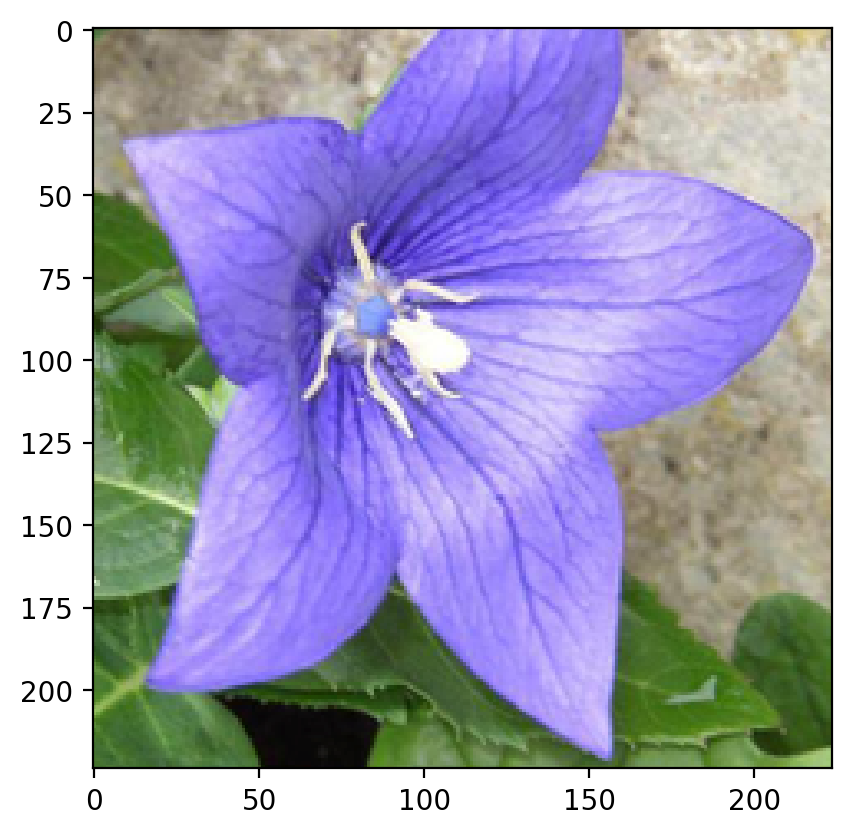

In [22]:
# Define the location of the images to preprocess
practice_img = "./flowers/test/19/image_06186.jpg"
# Additional images can be added and processed in the same way.

# Process the example image and display it
np_processed_image = process_image(practice_img)
imshow(np_processed_image)  # This will display the processed image

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
# Path to the file containing class-to-name mapping
category_names = 'cat_to_name.json'

def class_to_label(category_names, class_indices):
    """Convert class indices to actual labels using a category names file."""
    with open(category_names, 'r') as f:
        cat_to_name = json.load(f)
    labels = [cat_to_name[str(cls)] for cls in class_indices]
    return labels

def predict(image_path, model, idx_to_class, topk=5):
    """Predict the class (or classes) of an image using a trained deep learning model."""
    # Process the image and convert it to a tensor
    processed_image = torch.from_numpy(process_image(image_path)).float()
    processed_image = torch.unsqueeze(processed_image, 0).to(device)

    # Set the model to evaluation mode and predict
    model.to(device)
    model.eval()
    with torch.no_grad():
        log_ps = model(processed_image)
    ps = torch.exp(log_ps)

    # Get the top k probabilities and indices
    top_ps, top_idx = ps.topk(topk, dim=1)
    print("Predicted indices:", top_idx.tolist()[0])  # Add this line
    top_ps = top_ps.tolist()[0]
    top_idx = top_idx.tolist()[0]

    # Map indices to class labels
    classes = [idx_to_class[idx] for idx in top_idx]
    model.train()  # Set the model back to training mode

    return top_ps, classes

def print_predictions(probabilities, classes, image_name, category_names):
    """Print the predictions along with class names."""
    print(f"Predictions for image: {image_name}")

    labels = class_to_label(category_names, classes)
    for i, (ps, label) in enumerate(zip(probabilities, labels), 1):
        print(f"{i}) {ps * 100:.2f}% {label.title()}")


In [24]:
# Reverse the mapping from class index (number) to class label (string)
idx_mapping = {v: k for k, v in class_to_idx.items()}


# Predict the classes for an input image
probabilities, classes = predict(practice_img, model, idx_mapping, topk=5)

# Print out the predictions
print_predictions(probabilities, classes, practice_img.split('/')[-1], category_names)


Predicted indices: [13, 49, 0, 41, 83]
Predictions for image: image_06186.jpg
1) 100.00% Balloon Flower
2) 0.00% Petunia
3) 0.00% Pink Primrose
4) 0.00% Poinsettia
5) 0.00% Clematis


/tmp/ipykernel_61/2177049946.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((256, 50000), Image.ANTIALIAS)


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

/tmp/ipykernel_61/2177049946.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((256, 50000), Image.ANTIALIAS)


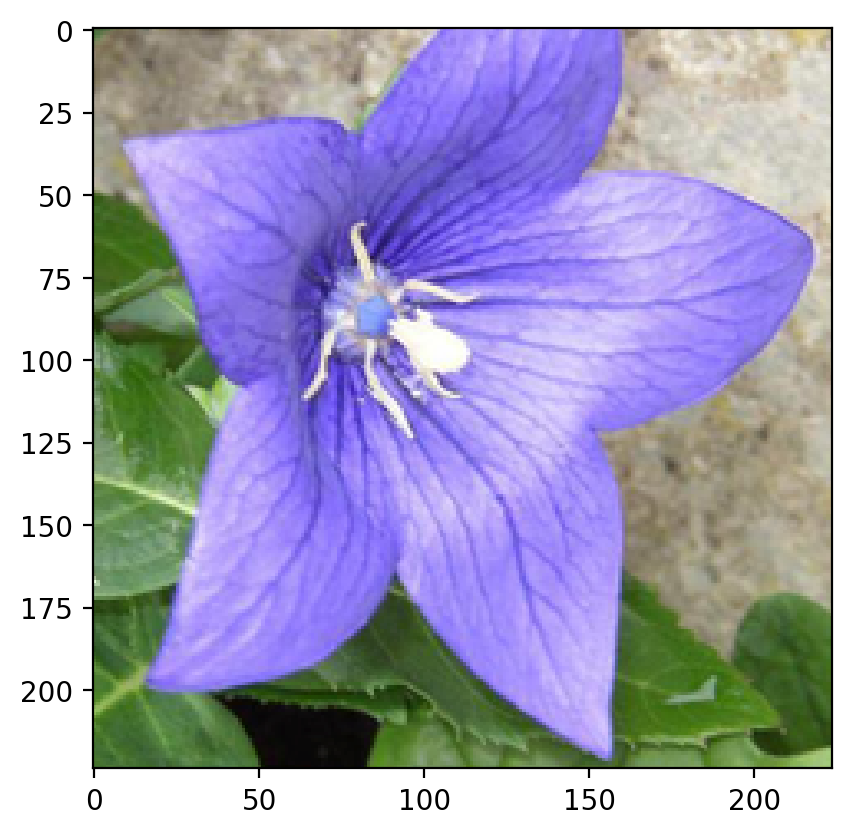

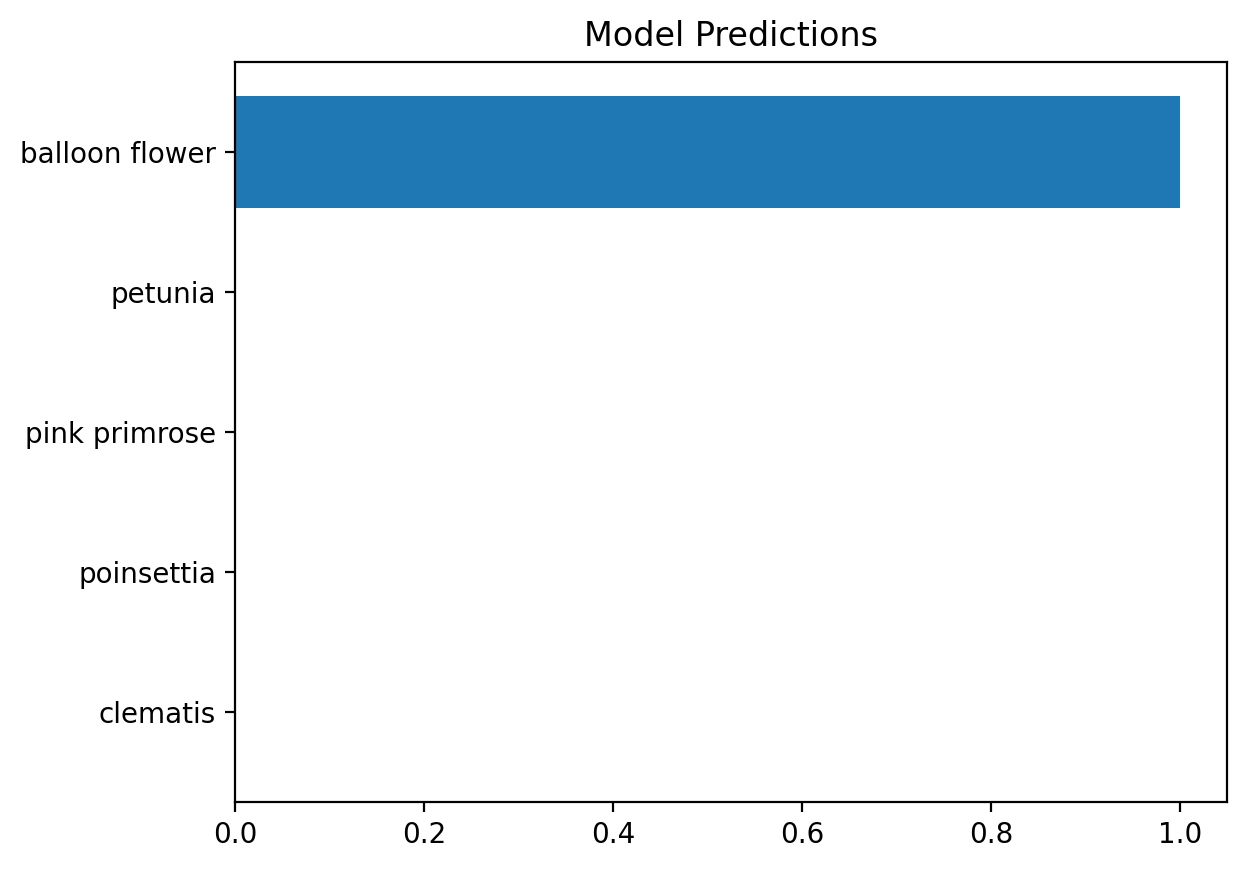

In [25]:
# TODO: Display an image along with the top 5 classes

# Display the processed image using the custom 'imshow' function
imshow(process_image(practice_img))

# Begin plotting a new figure with matplotlib for the prediction probabilities
plt.figure()  # Create a new figure for the predictions bar chart

# Generate a horizontal bar chart to represent the predicted class probabilities
# 'class_to_label' is a function that maps class indices to human-readable labels
# 'classes' should be a list of class indices, and 'probabilities' should be the corresponding probabilities
plt.barh(class_to_label(category_names, classes), width=probabilities)

# Set the title of the bar chart to 'Model Predictions'
plt.title('Model Predictions')

# Invert the y-axis to display the highest probability at the top of the chart
plt.gca().invert_yaxis()

# Display the bar chart with the predictions
plt.show()


## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [26]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
import os

checkpoint_path =  f"{model_arch}_checkpoint.pth"
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
